In [1]:
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.stats as s
import scipy.special as ss
import sortedcontainers as sc
import os
import tqdm
import matplotlib

In [2]:
os.environ["CAPY_REF_FA"] = "/home/opriebe/data/ref/hg19/Homo_sapiens_assembly19.fasta"
import hapaseg.coverage_MCMC as mcmc_cov
import hapaseg.NB_coverage_MCMC as nb_cov
from capy import mut, seq

Cannot find path to gnomAD index; gnomAD functionality disabled.


Load MCMC trace over SNP DP cluster assignments. Still looking at only the high purity exome

In [3]:
colors = mpl.cm.get_cmap("tab10").colors

### Load coverage

In [4]:
Cov = pd.read_csv("exome/6_C1D1_META.cov", sep = "\t", names = ["chr", "start", "end", "covcorr", "covraw"], low_memory=False)
Cov["chr"] = mut.convert_chr(Cov["chr"])
Cov = Cov.loc[Cov["chr"] != 0]
Cov["start_g"] = seq.chrpos2gpos(Cov["chr"], Cov["start"])
Cov["end_g"] = seq.chrpos2gpos(Cov["chr"], Cov["end"])

### Load covariates

In [5]:
Cov["C_len"] = Cov["end"] - Cov["start"] + 1

# load repl timing
F = pd.read_pickle("covars/GSE137764_H1.hg19_liftover.pickle")

# map targets to RT intervals
tidx = mut.map_mutations_to_targets(Cov.rename(columns = { "start" : "pos" }), F, inplace = False)
Cov.loc[tidx.index, "C_RT"] = F.iloc[tidx, 3:].mean(1).values

# z-transform
Cov["C_RT_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_RT"] + 1e-20))

#load GC content
B = pd.read_pickle("covars/GC.pickle")
Cov = Cov.merge(B.rename(columns = { "gc" : "C_GC" }), left_on = ["chr", "start", "end"], right_on = ["chr", "start", "end"], how = "left")
Cov["C_GC_z"] = (lambda x : (x - np.nanmean(x))/np.nanstd(x))(np.log(Cov["C_GC"] + 1e-20))

In [6]:
clust = np.load("exome/6_C1D1_META.DP_clusts.auto_ref_correct.overdispersion92.no_phase_correct.npz")

#### Load chromosome boundary coordinates

In [7]:
allelic_segs = pd.read_pickle("exome/6_C1D1_META.allelic_segs.auto_ref_correct.overdispersion92.no_phase_correct.pickle")
chrbdy = allelic_segs.dropna().loc[:, ["start", "end"]]
chr_ends = chrbdy.loc[chrbdy["start"] != 0, "end"].cumsum()

In [8]:
clust["snps_to_clusters"].shape

(500, 11768)

In [9]:
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

### load SNPs from single DP iteration

In [10]:
iter_ind = 499
SNPs = pd.read_pickle("exome/6_C1D1_META.SNPs.pickle")
SNPs["chr"], SNPs["pos"] = seq.gpos2chrpos(SNPs["gpos"])

SNPs["tidx"] = mut.map_mutations_to_targets(SNPs, Cov, inplace = False)

#generate unique clust assignments
clust_u, clust_uj = np.unique(clust["snps_to_clusters"], return_inverse = True)
clust_uj = clust_uj.reshape(clust["snps_to_clusters"].shape)

#assign coverage intervals to clusters
Cov_clust_probs = np.zeros([len(Cov), clust_u.max()])

for targ, snp_idx in SNPs.groupby("tidx").indices.items():
    targ_clust_hist = np.bincount(clust_uj[499, snp_idx].ravel(), minlength = clust_u.max())

    Cov_clust_probs[int(targ), :] = targ_clust_hist/targ_clust_hist.sum()

#subset intervals containing SNPs
overlap_idx = Cov_clust_probs.sum(1) > 0
Cov_clust_probs_overlap = Cov_clust_probs[overlap_idx, :]

#prune improbable assignments
Cov_clust_probs_overlap[Cov_clust_probs_overlap < 0.05] = 0
Cov_clust_probs_overlap /= Cov_clust_probs_overlap.sum(1)[:, None]
prune_idx = Cov_clust_probs_overlap.sum(0) > 0
Cov_clust_probs_overlap = Cov_clust_probs_overlap[:, prune_idx]

In [11]:
import scipy.stats
assgn_entropy = scipy.stats.entropy(Cov_clust_probs_overlap, axis=1)
entropy_idx = (assgn_entropy == 0)

#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

Cov_overlap = Cov_overlap.iloc[~naidx]

mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

almost all bins are unanimously assigned

In [12]:
#subsetting to only targets that overlap SNPs
Cov_overlap = Cov.loc[overlap_idx, :]

#subsetting to only targets with hard assignments
Cov_overlap = Cov_overlap.loc[entropy_idx,:]

r = np.c_[Cov_overlap["covcorr"]]

#making covariate matrix
C = np.c_[np.log(Cov_overlap["C_len"]), Cov_overlap["C_RT_z"], Cov_overlap["C_GC_z"]]

Pi = Cov_clust_probs_overlap[entropy_idx,:].copy()

In [13]:
#dropping Nans
naidx = np.isnan(C[:, 1])
r = r[~naidx]
C = C[~naidx]
Pi = Pi[~naidx]

In [14]:
Cov_overlap = Cov_overlap.iloc[~naidx]

In [15]:
mu = np.log(r.mean()*np.ones([Pi.shape[1], 1])) / 2
beta = np.ones([C.shape[1], 1])
mu_i = np.zeros(C.shape[0])
epsi = np.ones((mu.shape)) *2

In [16]:
Cov_overlap['cluster_assgn'] = np.argmax(Pi, axis=1)

In [17]:
cov_18 = Cov_overlap.loc[Cov_overlap['cluster_assgn'] == 18]
r_18 = np.c_[cov_18["covcorr"]]

#making covariate matrix
C_18 = np.c_[np.log(cov_18["C_len"]), cov_18["C_RT_z"], cov_18["C_GC_z"]]

In [18]:
nb_mcmc = nb_cov.NB_MCMC(r, C, Pi)

find ML splitting landscape for reasonable cluster

In [ ]:
cov_1 = Cov_overlap.loc[Cov_overlap['cluster_assgn'] == 1]
r_1 = np.c_[cov_1["covcorr"]]

#making covariate matrix
C_1 = np.c_[np.log(cov_1["C_len"]), cov_1["C_RT_z"], cov_1["C_GC_z"]]

In [ ]:
nb_mcmc.run(100, debug=True)

results from using our NR but with stats model rescue on failure

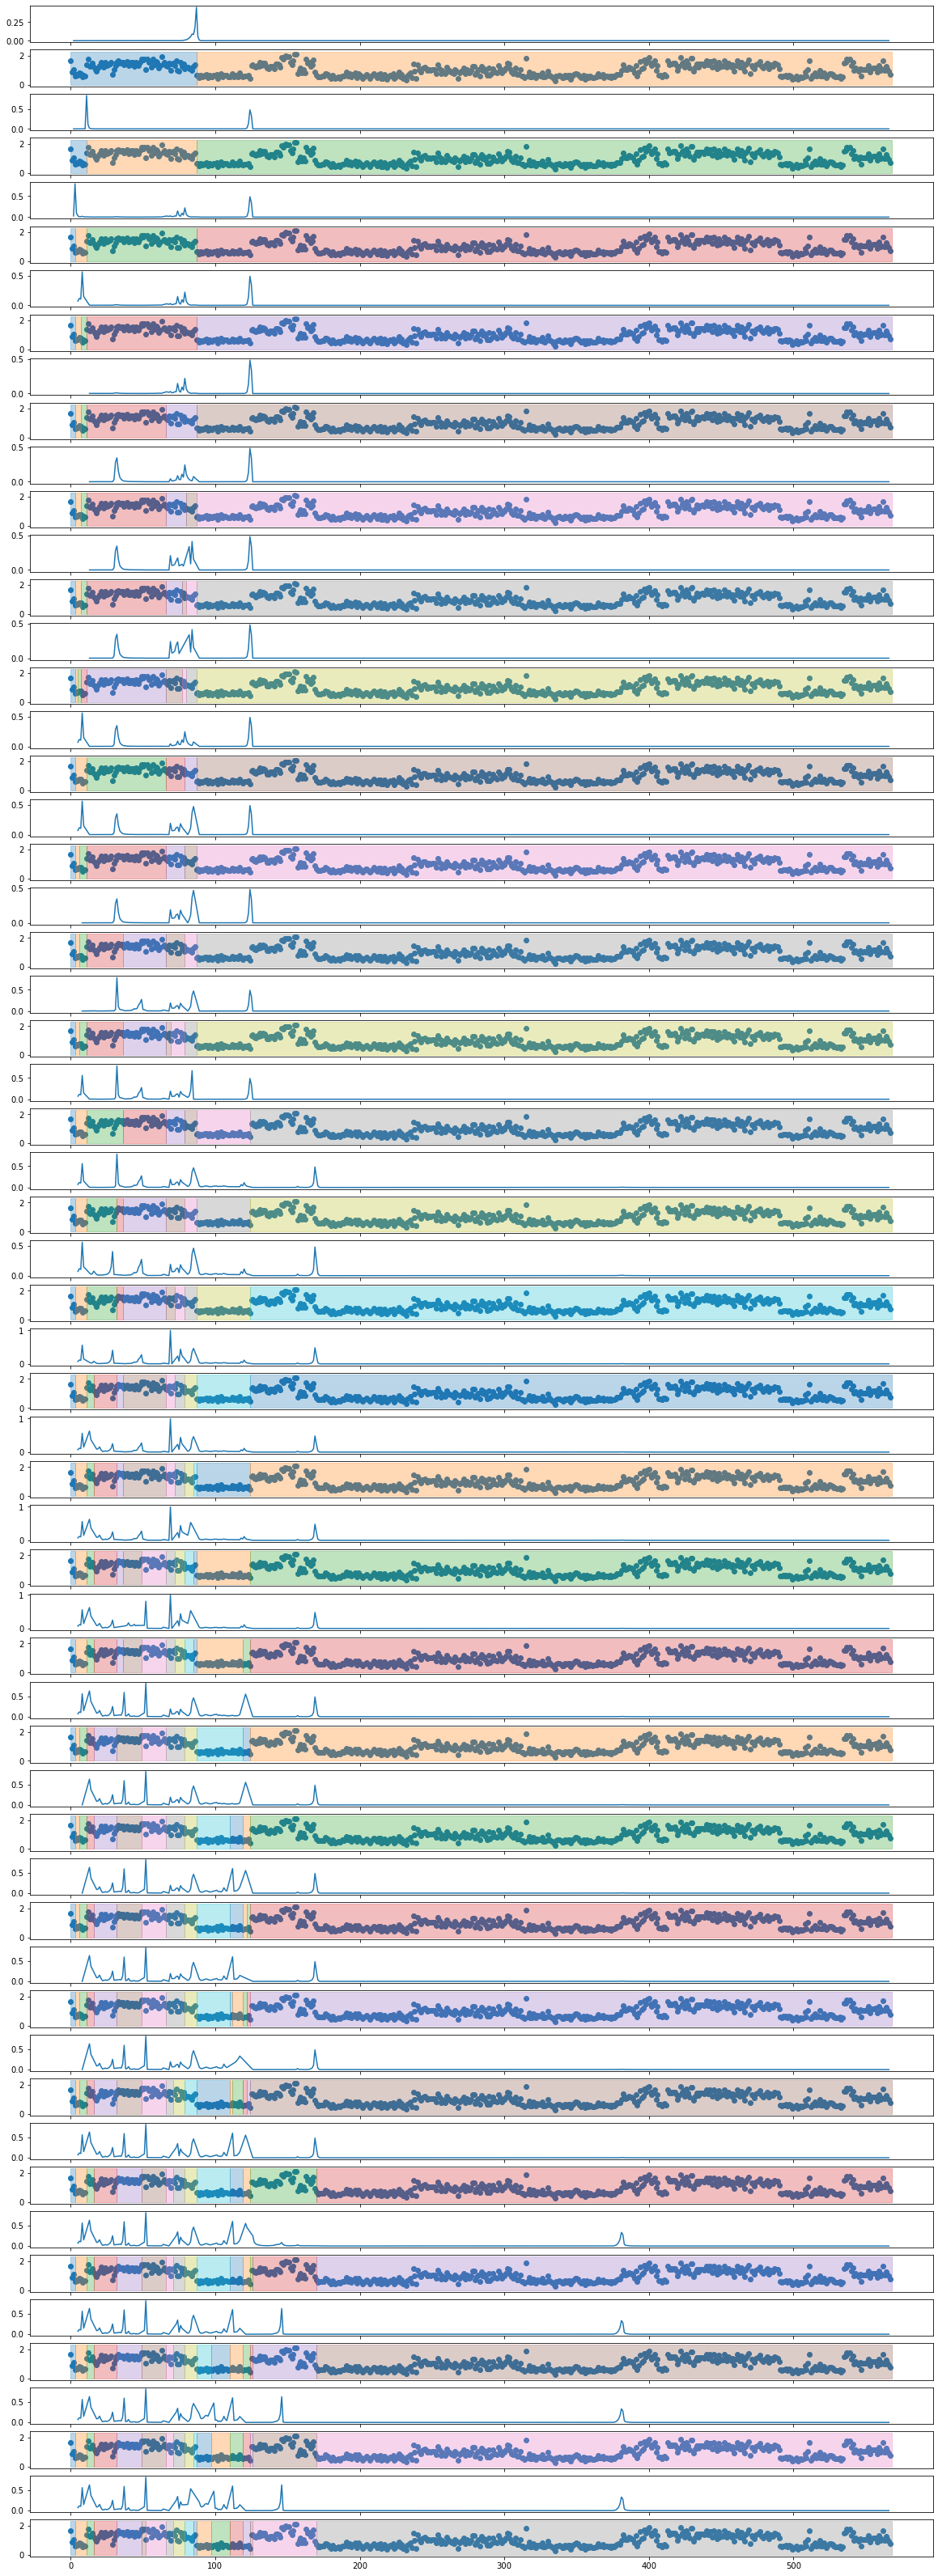

In [28]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,2 * len(traces)), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = np.exp(traces[i])
    nonzero = (trace != 1)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

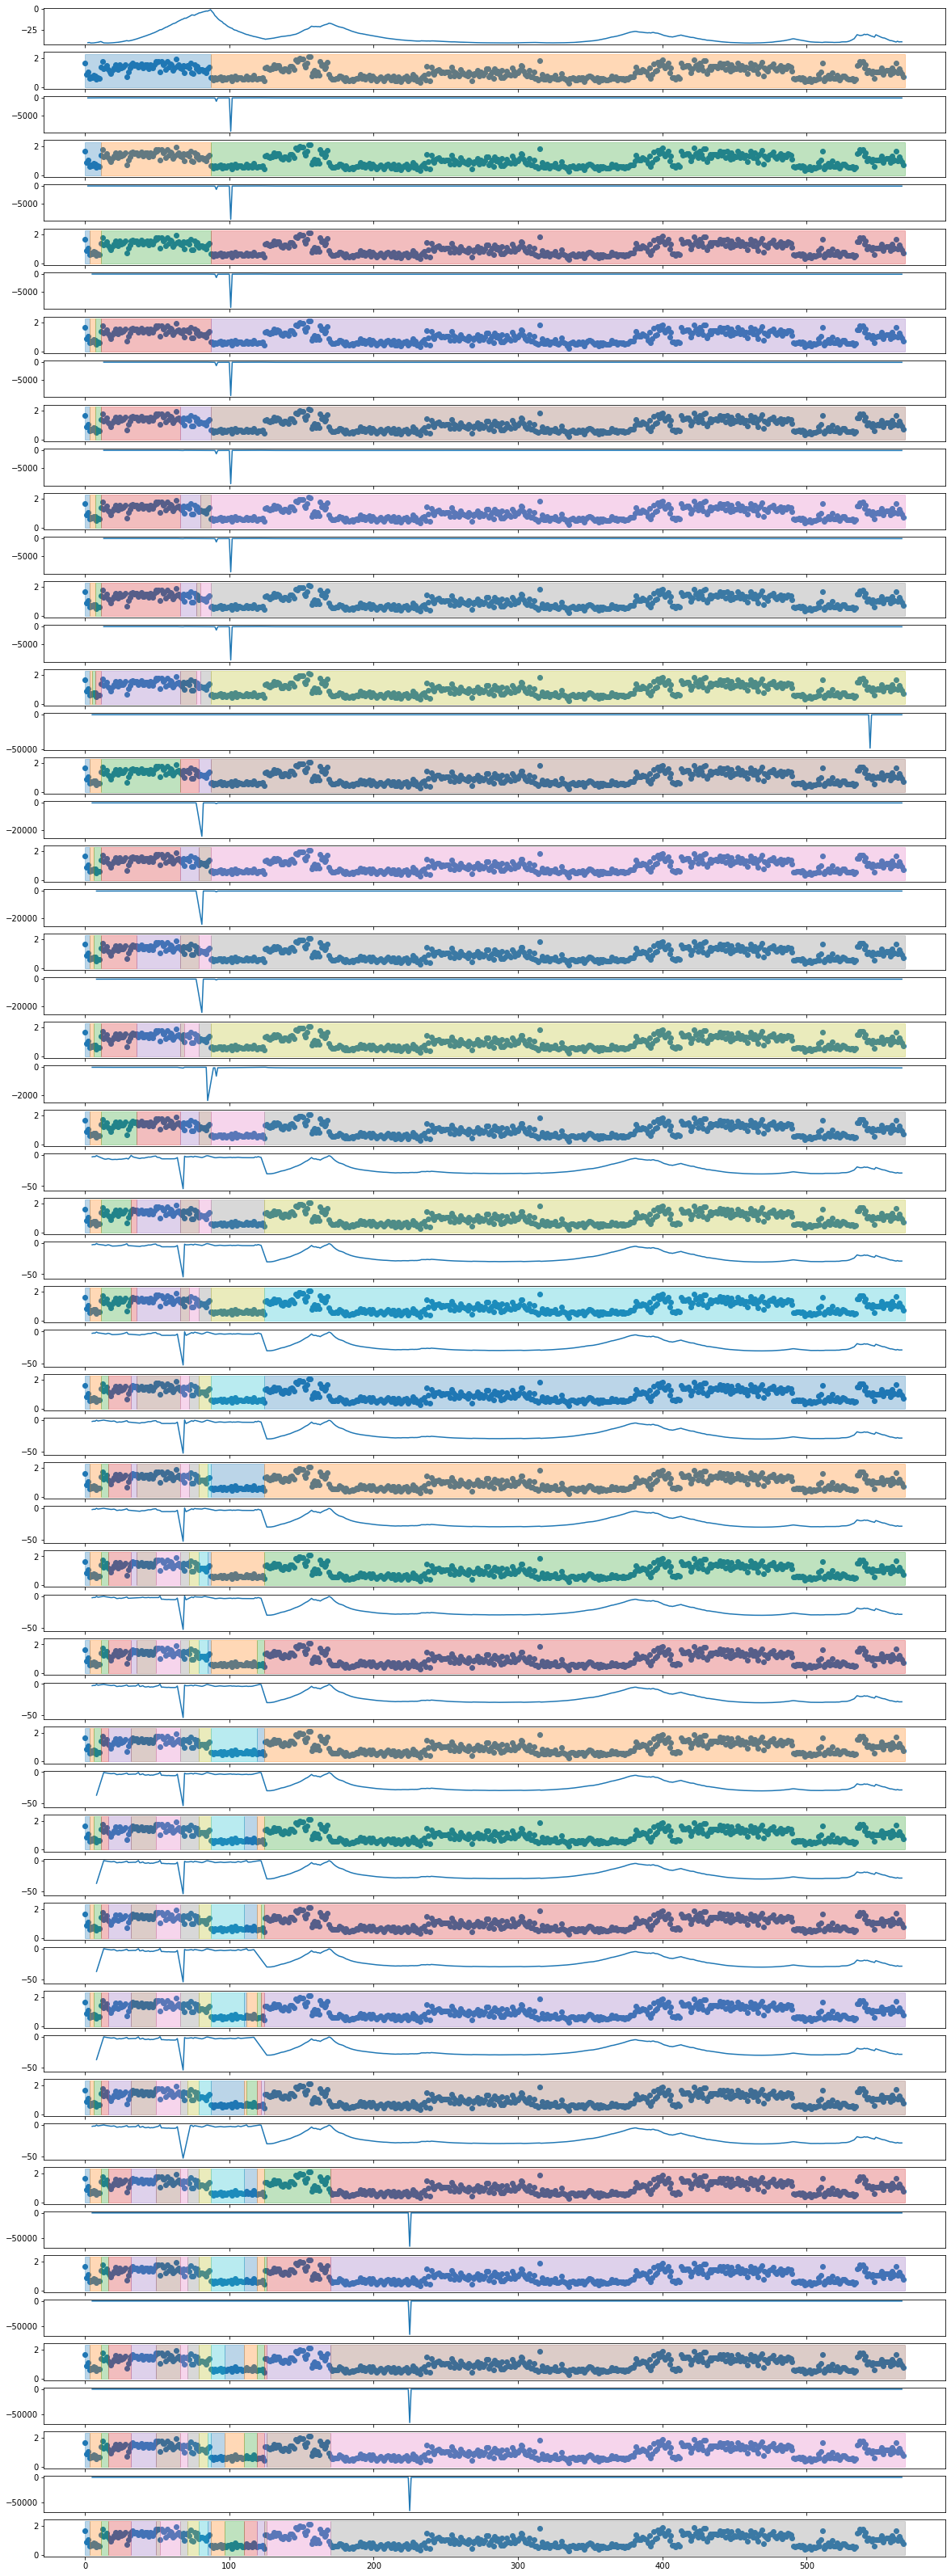

In [29]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,2 * len(traces)), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = traces[i]
    nonzero = (trace != 0)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

results from starting with statsmodels parameters

In [20]:
nb_mcmc.run(100, debug=True)

  0%|          | 0/100 [00:00<?, ?it/s]

starting MCMC coverage segmentation...
SortedDict({0: 568})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 568)


  1%|          | 1/100 [00:08<13:41,  8.30s/it]

split log ml ratio:  34.589492426344805
split log mh ratio:  35.392098497451116
split!
SortedList([0, 87, 87, 568])
SortedDict({0: 87, 87: 481})
trying to join cluster 1
attempting join on segs: 0 87
join ind:  (0, 568)


  2%|▏         | 2/100 [00:16<13:24,  8.21s/it]

SortedDict({0: 87, 87: 481})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (87, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


  3%|▎         | 3/100 [00:24<13:14,  8.19s/it]

split log ml ratio:  22.046717505668312
split log mh ratio:  24.247426216063104
split!
SortedList([0, 12, 12, 87, 87, 568])
SortedDict({0: 12, 12: 75, 87: 481})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (0, 12)
s_ind: 12 (87, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tr

  4%|▍         | 4/100 [00:32<13:04,  8.17s/it]

split log ml ratio:  -0.11432390927166125
split log mh ratio:  3.4729169625252325
split!
SortedList([0, 12, 12, 81, 81, 87, 87, 568])
SortedDict({0: 12, 12: 69, 81: 6, 87: 481})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  5%|▌         | 5/100 [00:40<12:51,  8.12s/it]

failing to converge. Trying grid search
s_ind: 87 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
split log ml ratio:  40.89884903917391
split log mh ratio:  41.6194702268931
split!
SortedList([0, 12, 12, 81, 81, 87, 87, 124, 124, 568])
SortedDict({0: 12, 12: 69, 81: 6, 87: 37, 124: 444})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 12)
s_ind: 0 (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 0 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (124, 568)


  6%|▌         | 6/100 [00:49<12:50,  8.20s/it]

split log ml ratio:  -1.0875444676848929
split log mh ratio:  1.6935051103428123
split!
SortedList([0, 5, 5, 12, 12, 81, 81, 87, 87, 124, 124, 568])
SortedDict({0: 5, 5: 7, 12: 69, 81: 6, 87: 37, 124: 444})
trying to join cluster 1
attempting join on segs: 0 5
join ind:  (0, 12)
joining!
SortedList([0, 12, 12, 81, 81, 87, 87, 124, 124, 568])
SortedDict({0: 12, 5: 7, 12: 69, 81: 6, 87: 37, 124: 444})
trying to split cluster 1
attempting split on segment:  81
ind:  (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 81 (0, 12)
s_ind: 81 (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (124, 568)


  8%|▊         | 8/100 [00:57<09:34,  6.25s/it]

split log ml ratio:  -1.3608054559254015
split log mh ratio:  0.9032660046013916
split!
SortedList([0, 12, 12, 81, 81, 83, 83, 87, 87, 124, 124, 568])
SortedDict({0: 12, 5: 7, 12: 69, 81: 2, 83: 4, 87: 37, 124: 444})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 568)
s_ind: 124 (0, 12)
s_ind: 124 (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 124 (83, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 124 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  9%|▉         | 9/100 [01:05<10:15,  6.77s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
split log ml ratio:  24.189955931457007
split log mh ratio:  25.612684647649075
split!
SortedList([0, 12, 12, 81, 81, 83, 83, 87, 87, 124, 124, 170, 170, 568])
SortedDict({0: 12, 5: 7, 12: 69, 81: 2, 83: 4, 87: 37, 124: 46, 170: 398})
trying to split cluster 1
attempting split on segment:  87
ind:  (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 87 (0, 12)
s_ind: 87 (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 87 (83, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 87 (124, 170)
s_ind: 87 (170, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search


 10%|█         | 10/100 [01:14<10:46,  7.18s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 11%|█         | 11/100 [01:14<07:43,  5.21s/it]

failing to converge. Trying grid search
split log ml ratio:  -3.241789667311423
split log mh ratio:  0.07060597676536418
split!
SortedList([0, 12, 12, 81, 81, 83, 83, 87, 87, 101, 101, 124, 124, 170, 170, 568])
SortedDict({0: 12, 5: 7, 12: 69, 81: 2, 83: 4, 87: 14, 101: 23, 124: 46, 170: 398})
trying to join cluster 1
attempting join on segs: 81 83
join ind:  (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
joining!
SortedList([0, 12, 12, 81, 81, 87, 87, 101, 101, 124, 124, 170, 170, 568])
SortedDict({0: 12, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 46, 170: 398})
trying to join cluster 1
attempting join on segs: 101 124
join ind:  (101, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. 

 12%|█▏        | 12/100 [01:15<05:48,  3.97s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 12, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 46, 170: 398})
trying to join cluster 1
attempting join on segs: 81 87
join ind:  (81, 101)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 13%|█▎        | 13/100 [01:15<04:19,  2.98s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 12, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 46, 170: 398})
trying to join cluster 1
attempting join on segs: 81 87
join ind:  (81, 101)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 14%|█▍        | 14/100 [01:16<03:15,  2.27s/it]

trying stats opt
SortedDict({0: 12, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 46, 170: 398})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 170)
s_ind: 124 (0, 12)
s_ind: 124 (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 124 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 124 (87, 101)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 124 (101, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 124 (170, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 15%|█▌        | 15/100 [01:24<05:37,  3.97s/it]

split log ml ratio:  3.399612356402031
split log mh ratio:  4.793324365282388
split!
SortedList([0, 12, 12, 81, 81, 87, 87, 101, 101, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 12, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 12)
s_ind: 0 (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 0 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (87, 101)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 0 (101, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (170, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search


 16%|█▌        | 16/100 [01:32<07:25,  5.30s/it]

split log ml ratio:  0.7513384861103987
split log mh ratio:  1.6029748005548758
split!
SortedList([0, 3, 3, 12, 12, 81, 81, 87, 87, 101, 101, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 124 126
join ind:  (124, 170)


 17%|█▋        | 17/100 [01:33<05:19,  3.85s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 81 87
join ind:  (81, 101)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 18%|█▊        | 18/100 [01:33<03:55,  2.87s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 81 87
join ind:  (81, 101)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 19%|█▉        | 19/100 [01:34<02:55,  2.17s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/

trying stats opt
SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 81 87
join ind:  (81, 101)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 20%|██        | 20/100 [01:34<02:14,  1.68s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failin

 21%|██        | 21/100 [01:41<04:00,  3.04s/it]

SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 22%|██▏       | 22/100 [01:47<05:12,  4.01s/it]

SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  124
SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tryin

 24%|██▍       | 24/100 [01:53<04:33,  3.60s/it]

SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 25%|██▌       | 25/100 [01:59<05:19,  4.27s/it]

SortedDict({0: 3, 3: 9, 5: 7, 12: 69, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 12 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (81, 87)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (87, 101)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 12 (101, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (170, 568)
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search


 26%|██▌       | 26/100 [02:08<06:36,  5.36s/it]

split log ml ratio:  -2.288595690202783
split log mh ratio:  1.6412665251382341
split!
SortedList([0, 3, 3, 12, 12, 36, 36, 81, 81, 87, 87, 101, 101, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 3 12
join ind:  (3, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|██▋       | 27/100 [02:08<04:55,  4.05s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to conv

 28%|██▊       | 28/100 [02:14<05:34,  4.64s/it]

SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 101 124
join ind:  (101, 126)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 29%|██▉       | 29/100 [02:15<04:03,  3.43s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 14, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 87 101
join ind:  (87, 124)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 30%|███       | 30/100 [02:16<03:21,  2.88s/it]

failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 12, 12, 36, 36, 81, 81, 87, 87, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 3 12
join ind:  (3, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 31%|███       | 31/100 [02:17<02:31,  2.19s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 12)
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 3 12
join ind:  (3, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 33%|███▎      | 33/100 [02:18<01:29,  1.34s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to conv

 34%|███▍      | 34/100 [02:24<02:47,  2.54s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 87 124
join ind:  (87, 126)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 35%|███▌      | 35/100 [02:25<02:19,  2.15s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 24, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (36, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 12 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search


 36%|███▌      | 36/100 [02:34<04:15,  3.98s/it]

split log ml ratio:  2.6401264807436746
split log mh ratio:  2.8692856045627195
split!
SortedList([0, 3, 3, 12, 12, 32, 32, 36, 36, 81, 81, 87, 87, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 20, 32: 4, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 126 170
join ind:  (126, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Try

 37%|███▋      | 37/100 [02:40<04:49,  4.60s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 3, 3: 9, 5: 7, 12: 20, 32: 4, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to join cluster 1
attempting join on segs: 3 12
join ind:  (3, 32)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 38%|███▊      | 38/100 [02:40<03:30,  3.40s/it]

SortedDict({0: 3, 3: 9, 5: 7, 12: 20, 32: 4, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 32)
s_ind: 12 (3, 12)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (36, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 12 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search


 39%|███▉      | 39/100 [02:49<05:06,  5.02s/it]

split log ml ratio:  -1.4696311503503239
split log mh ratio:  1.7557974246701633
split!
SortedList([0, 3, 3, 12, 12, 26, 26, 32, 32, 36, 36, 81, 81, 87, 87, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 14, 26: 6, 32: 4, 36: 45, 81: 6, 83: 4, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  81
ind:  (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (12, 26)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (26, 32)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (36, 81)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (170, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 40%|████      | 40/100 [03:07<08:43,  8.73s/it]

split log ml ratio:  0.15926688312720216
split log mh ratio:  0.7491725253885306
split!
SortedList([0, 3, 3, 12, 12, 26, 26, 32, 32, 36, 36, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 14, 26: 6, 32: 4, 36: 45, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 398})
trying to split cluster 1
attempting split on segment:  170
ind:  (170, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 170 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (12, 26)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (26, 32)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 170 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (36, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 170 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 170 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 41%|████      | 41/100 [03:16<08:38,  8.79s/it]

split log ml ratio:  56.66160666187898
split log mh ratio:  57.76793428451401
split!
SortedList([0, 3, 3, 12, 12, 26, 26, 32, 32, 36, 36, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 14, 26: 6, 32: 4, 36: 45, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  36
ind:  (36, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 36 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 36 (12, 26)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 36 (26, 32)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

s_ind: 36 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 36 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 36 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 36 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 36 (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 42%|████▏     | 42/100 [03:25<08:29,  8.79s/it]

split log ml ratio:  -1.6848476623617898
split log mh ratio:  3.7398090573915406
split!
SortedList([0, 3, 3, 12, 12, 26, 26, 32, 32, 36, 36, 57, 57, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 14, 26: 6, 32: 4, 36: 21, 57: 24, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  26
ind:  (26, 32)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 26 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 26 (12, 26)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 26 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 26 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 26 (57, 81)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 26 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 26 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 26 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 26 (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 43%|████▎     | 43/100 [03:34<08:19,  8.77s/it]

split log ml ratio:  0.8813116610672296
split log mh ratio:  1.6722729734956374
split!
SortedList([0, 3, 3, 12, 12, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 14, 26: 2, 28: 4, 32: 4, 36: 21, 57: 24, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 26)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (28, 32)
s_ind: 12 (32, 36)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (57, 81)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 12 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 12 (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 44%|████▍     | 44/100 [03:42<08:09,  8.74s/it]

split log ml ratio:  -1.6561267761271665
split log mh ratio:  0.8233526785888889
split!
SortedList([0, 3, 3, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 12, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 24, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  57
ind:  (57, 81)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 57 (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 57 (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 57 (28, 32)
s_ind: 57 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 57 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 57 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 57 (126, 170)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 57 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 57 (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 45%|████▌     | 45/100 [03:51<08:01,  8.75s/it]

split log ml ratio:  -1.5673593533774692
split log mh ratio:  1.9167272147824406
split!
SortedList([0, 3, 3, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 12, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (3, 12)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (28, 32)
s_ind: 12 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (57, 77)
failing to converge. Trying grid search
s_ind: 12 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (87, 124)
failing to converge. Trying grid search
tryin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 12 (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 46%|████▌     | 46/100 [03:59<07:48,  8.68s/it]

split log ml ratio:  -0.740766827070729
split log mh ratio:  0.9487954772939702
split!
SortedList([0, 3, 3, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 9, 5: 7, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  124
SortedDict({0: 3, 3: 9, 5: 7, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to join cluster 1
attempting join on segs: 77 81
join ind:  (77, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 48%|████▊     | 48/100 [04:00<04:06,  4.73s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to join cluster 1
attempting join on segs: 3 12
join ind:  (3, 16)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 49%|████▉     | 49/100 [04:00<03:05,  3.65s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 3: 9, 5: 7, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  3
ind:  (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (12, 16)
failing to converge. Trying grid search
s_ind: 3 (16, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (28, 32)
s_ind: 3 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (57, 77)
failing to converge. Trying grid search
s_ind: 3 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 3 (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 51%|█████     | 51/100 [04:09<03:12,  3.93s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 52%|█████▏    | 52/100 [04:09<02:27,  3.07s/it]

split log ml ratio:  1.1295983452500877
split log mh ratio:  2.7534920916596093
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to join cluster 1
attempting join on segs: 12 16
join ind:  (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  124
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 54%|█████▍    | 54/100 [04:09<01:26,  1.89s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to join cluster 1
attempting join on segs: 12 16
join ind:  (12, 24)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 55%|█████▌    | 55/100 [04:09<01:08,  1.51s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  24
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to join cluster 1
attempting join on segs: 32 36
join ind:  (32, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 57%|█████▋    | 57/100 [04:10<00:45,  1.06s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to join cluster 1
attempting join on segs: 3 8
join ind:  (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|█████▊    | 58/100 [04:10<00:36,  1.15it/s]

failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 187})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 381 (8, 12)
failing to converge. Trying grid search
s_ind: 381 (12, 16)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 381 (16, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (28, 32)
s_ind: 381 (32, 36)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (57, 77)
failing to converge. Trying grid search
s_ind: 381 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid sea

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 59%|█████▉    | 59/100 [04:19<01:53,  2.76s/it]/home/opriebe/anaconda

failing to converge. Trying grid search
trying stats opt
split log ml ratio:  39.38245348860255
split log mh ratio:  39.972108703965205
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 491, 491, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 28 32
join ind:  (28, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 60%|██████    | 60/100 [04:19<01:24,  2.11s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to split cluster 1
attempting split on segment:  26
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 16)
failing to converge. Trying grid search
s_ind: 12 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 12 (8, 12)
failing to converge. Trying grid search
s_ind: 12 (16, 24)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (28, 32)
s_ind: 12 (32, 36)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 12 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (57, 77)
failing to converge. Trying grid search
s_ind: 12 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 12 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 12 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (491, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 62%|██████▏   | 62/100 [04:28<01:58,  3.13s/it]

split log ml ratio:  -1.1953316697454284
split log mh ratio:  -1.195331669745428
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 84 87
join ind:  (84, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to conve

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 63%|██████▎   | 63/100 [04:29<01:37,  2.63s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 124 126
join ind:  (124, 170)


 64%|██████▍   | 64/100 [04:30<01:15,  2.09s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 12 16
join ind:  (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 65%|██████▌   | 65/100 [04:30<00:56,  1.60s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


joining!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 381, 381, 491, 491, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 26 28
join ind:  (26, 32)
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 211, 381: 110, 491: 77})
trying to split cluster 1
attempting split on segment:  170
ind:  (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
trying stats opt
s_ind: 170 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 170 (8, 12)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 170 (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (28, 32)
s_ind: 170 (32, 36)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (57, 77)
failing to converge. Trying grid search
s_ind: 170 (77, 81)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 170 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 170 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 67%|██████▋   | 67/100 [04:39<01:35,  2.88s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 68%|██████▊   | 68/100 [04:39<01:11,  2.24s/it]

split log ml ratio:  24.05036602632663
split log mh ratio:  25.791235306060116
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 84, 84, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 491, 491, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 3, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 77})
trying to join cluster 1
attempting join on segs: 81 84
join ind:  (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 491, 491, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 6, 83: 4, 84:

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 6, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 77})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 491 (8, 12)
failing to converge. Trying grid search
s_ind: 491 (12, 24)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (28, 32)
s_ind: 491 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (57, 77)
failing to converge. Trying grid search
s_ind: 491 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (87, 124)
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 491 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 70%|███████   | 70/100 [04:48<01:34,  3.15s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
split log ml ratio:  26.640125614797398
split log mh ratio:  30.102083476655025
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 491, 491, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 6, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  316
ind:  (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
trying stats opt
s_ind: 316 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 316 (8, 12)
failing to converge. Trying grid search
s_ind: 316 (12, 24)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (28, 32)
s_ind: 316 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (57, 77)
failing to converge. Trying grid search
s_ind: 316 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (87, 124)
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 316 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (491, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid sea

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 316 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:354: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 71%|███████   | 71/100 [04:57<02:08,  4.42s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 6, 83: 4, 84: 3, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  81
ind:  (81, 87)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
trying stats opt
s_ind: 81 (8, 12)
failing to converge. Trying grid search
s_ind: 81 (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (28, 32)
s_ind: 81 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (57, 77)
failing to converge. Trying grid search
s_ind: 81 (77, 81)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 81 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 81 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 81 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (491, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 81 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 72%|███████▏  | 72/100 [05:06<02:33,  5.49s/it]

split log ml ratio:  -0.23908295648470812
split log mh ratio:  0.8347569623992972
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 491, 491, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  26
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  32
ind:  (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (3, 8)
failing to converge. Trying grid search
failing to converge. Tryin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

s_ind: 32 (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (28, 32)
s_ind: 32 (36, 57)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (57, 77)
failing to converge. Trying grid search
s_ind: 32 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 32 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 32 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (491, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|███████▍  | 74/100 [05:15<02:11,  5.04s/it]

failing to converge. Trying grid search
split log ml ratio:  -2.7110818459832444
split log mh ratio:  -2.711081845983244
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to join cluster 1
attempting join on segs: 316 381
join ind:  (316, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 75%|███████▌  | 75/100 [05:17<01:49,  4.40s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  32
ind:  (32, 36)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 32 (8, 12)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 32 (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (28, 32)
s_ind: 32 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (57, 77)
failing to converge. Trying grid search
s_ind: 32 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (87, 124)
failing to converge. Tryin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (170, 316)
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 32 (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (491, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 32 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 76%|███████▌  | 76/100 [05:26<02:11,  5.46s/it]

failing to converge. Trying grid search
split log ml ratio:  -2.7110818459832444
split log mh ratio:  -2.711081845983244
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 110, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  381
ind:  (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying gr

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (28, 32)
s_ind: 381 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (57, 77)
failing to converge. Trying grid search
s_ind: 381 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid sea

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

trying stats opt
s_ind: 381 (491, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 381 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 77%|███████▋  | 77/100 [05:34<02:24,  6.28s/it]

split log ml ratio:  17.10919027883483
split log mh ratio:  17.745180746742335
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 491, 491, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  124
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 43, 534: 34})
trying to split cluster 1
attempting split on segment:  491
ind:  (491, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to conve

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying stats opt
s_ind: 491 (8, 12)
failing to converge. Trying grid search
s_ind: 491 (12, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 491 (28, 32)
s_ind: 491 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (57, 77)
failing to converge. Trying grid search
s_ind: 491 (77, 81)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 491 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid sea

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 491 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 491 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (413, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 491 (534, 568)


 79%|███████▉  | 79/100 [05:43<01:55,  5.50s/it]

split log ml ratio:  3.8854202934289788
split log mh ratio:  6.187422126346064
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid se

 80%|████████  | 80/100 [05:45<01:31,  4.59s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 12, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  12
ind:  (12, 24)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/bas

trying stats opt
s_ind: 12 (8, 12)
failing to converge. Trying grid search
s_ind: 12 (28, 32)
s_ind: 12 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (57, 77)
failing to converge. Trying grid search
s_ind: 12 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to con

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 12 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 12 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (413, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (491, 498)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (498, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 12 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 81%|████████  | 81/100 [05:54<01:47,  5.65s/it]

split log ml ratio:  -0.740766827070729
split log mh ratio:  0.9487954772939702
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  77
ind:  (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 77 (8, 12)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
s_ind: 77 (12, 16)
failing to converge. Trying grid search
s_ind: 77 (16, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 77 (28, 32)
s_ind: 77 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (57, 77)
failing to converge. Trying grid search
s_ind: 77 (81, 85)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 77 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 77 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 77 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (413, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (491, 498)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (498, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 77 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 82%|████████▏ | 82/100 [06:03<01:58,  6.56s/it]

split log ml ratio:  -0.875494712762702
split log mh ratio:  -0.8754947127627015
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to c

 83%|████████▎ | 83/100 [06:04<01:28,  5.18s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 28 32
join ind:  (28, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 84%|████████▍ | 84/100 [06:04<01:00,  3.78s/it]

SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 78, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 413 (8, 12)
failing to converge. Trying grid search
s_ind: 413 (12, 16)
failing to converge. Trying grid search
s_ind: 413 (16, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (28, 32)
s_ind: 413 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (57, 77)
failing to converge. Trying grid search
s_ind: 413 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (170, 3

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 413 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 413 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (491, 498)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (498, 534)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 85%|████████▌ | 85/100 [06:13<01:18,  5.23s/it]

split log ml ratio:  0.7563836481085673
split log mh ratio:  2.6226312458511525
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 419, 419, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 72, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  419
ind:  (419, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to c

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 419 (16, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (28, 32)
s_ind: 419 (32, 36)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 419 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (57, 77)
failing to converge. Trying grid search
s_ind: 419 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (81, 85)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid sea

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 419 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 419 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (413, 419)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 419 (491, 498)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (498, 534)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 419 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 86%|████████▌ | 86/100 [06:22<01:28,  6.31s/it]

split log ml ratio:  -0.2406519232044957
split log mh ratio:  2.0825050920857398
split!
SortedList([0, 3, 3, 8, 8, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 419, 419, 474, 474, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  413
ind:  (413, 419)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 413 (3, 8)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 413 (8, 12)
failing to converge. Trying grid search
s_ind: 413 (12, 16)
failing to converge. Trying grid search
s_ind: 413 (16, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (28, 32)
s_ind: 413 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (57, 77)
failing to converge. Trying grid search
s_ind: 413 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 413 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 413 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (419, 474)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (474, 491)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (491, 498)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (498, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 413 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 87%|████████▋ | 87/100 [06:31<01:32,  7.11s/it]

failing to converge. Trying grid search
split log ml ratio:  -1.9381513445077871
split log mh ratio:  -0.3936446402567517
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 16 24
join ind:  (16, 26)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 88%|████████▊ | 88/100 [06:31<01:00,  5.08s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 170 316
join ind:  (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 89%|████████▉ | 89/100 [06:35<00:49,  4.48s/it]/home/opriebe/anaconda

failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 170 316
join ind:  (170, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 90%|█████████ | 90/100 [06:37<00:40,  4.03s/it]/home/opriebe/anaconda

failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 5, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 3 8
join ind:  (3, 12)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 91%|█████████ | 91/100 [06:38<00:25,  2.89s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 12, 12, 16, 16, 24, 24, 26, 26, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 419, 419, 474, 474, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 8, 24: 2, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 24 26
join ind:  (24, 28)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 12, 12, 16, 16, 24, 24, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 419, 419, 474, 474, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 1

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 16 (12, 16)
failing to converge. Trying grid search
s_ind: 16 (24, 28)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (28, 32)
s_ind: 16 (32, 36)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (36, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (57, 77)
failing to converge. Trying grid search
s_ind: 16 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (170, 316)
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 16 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 16 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (413, 419)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 16 (419, 474)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (474, 491)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (491, 498)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (498, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 16 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 93%|█████████▎| 93/100 [06:47<00:25,  3.65s/it]

split log ml ratio:  -1.4103849880475536
split log mh ratio:  1.2738460929986113
split!
SortedList([0, 3, 3, 12, 12, 16, 16, 18, 18, 24, 24, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 170, 170, 316, 316, 381, 381, 413, 413, 419, 419, 474, 474, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 419 474
join ind:  (419, 491)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 94%|█████████▍| 94/100 [06:48<00:17,  2.99s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 44, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 170)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 126 (18, 24)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (24, 28)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (28, 32)
s_ind: 126 (32, 36)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 126 (36, 57)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (57, 77)
failing to converge. Trying grid search
s_ind: 126 (77, 81)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


s_ind: 126 (81, 85)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (87, 124)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 126 (170, 316)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
s_ind: 126 (316, 381)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 126 (381, 413)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (413, 419)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 126 (419, 474)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (474, 491)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (491, 498)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (498, 534)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (534, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 95%|█████████▌| 95/100 [06:57<00:22,  4.58s/it]

split log ml ratio:  8.162410889007333
split log mh ratio:  9.785919913487305
split!
SortedList([0, 3, 3, 12, 12, 16, 16, 18, 18, 24, 24, 28, 28, 32, 32, 36, 36, 57, 57, 77, 77, 81, 81, 85, 85, 87, 87, 124, 124, 126, 126, 145, 145, 170, 170, 316, 316, 381, 381, 413, 413, 419, 419, 474, 474, 491, 491, 498, 498, 534, 534, 568])
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 19, 145: 25, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 381 413
join ind:  (381, 419)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 96%|█████████▌| 96/100 [06:57<00:14,  3.50s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 19, 145: 25, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  16
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 19, 145: 25, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 10

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/m

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 9, 5: 7, 8: 4, 12: 4, 16: 2, 18: 6, 24: 4, 26: 2, 28: 4, 32: 4, 36: 21, 57: 20, 77: 4, 81: 4, 83: 4, 84: 3, 85: 2, 87: 37, 101: 23, 124: 2, 126: 19, 145: 25, 170: 146, 316: 65, 381: 32, 413: 6, 419: 55, 474: 17, 491: 7, 498: 36, 534: 34})
trying to join cluster 1
attempting join on segs: 32 36
join ind:  (32, 57)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


100%|██████████| 100/100 [06:59<00:00,  4.20s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search


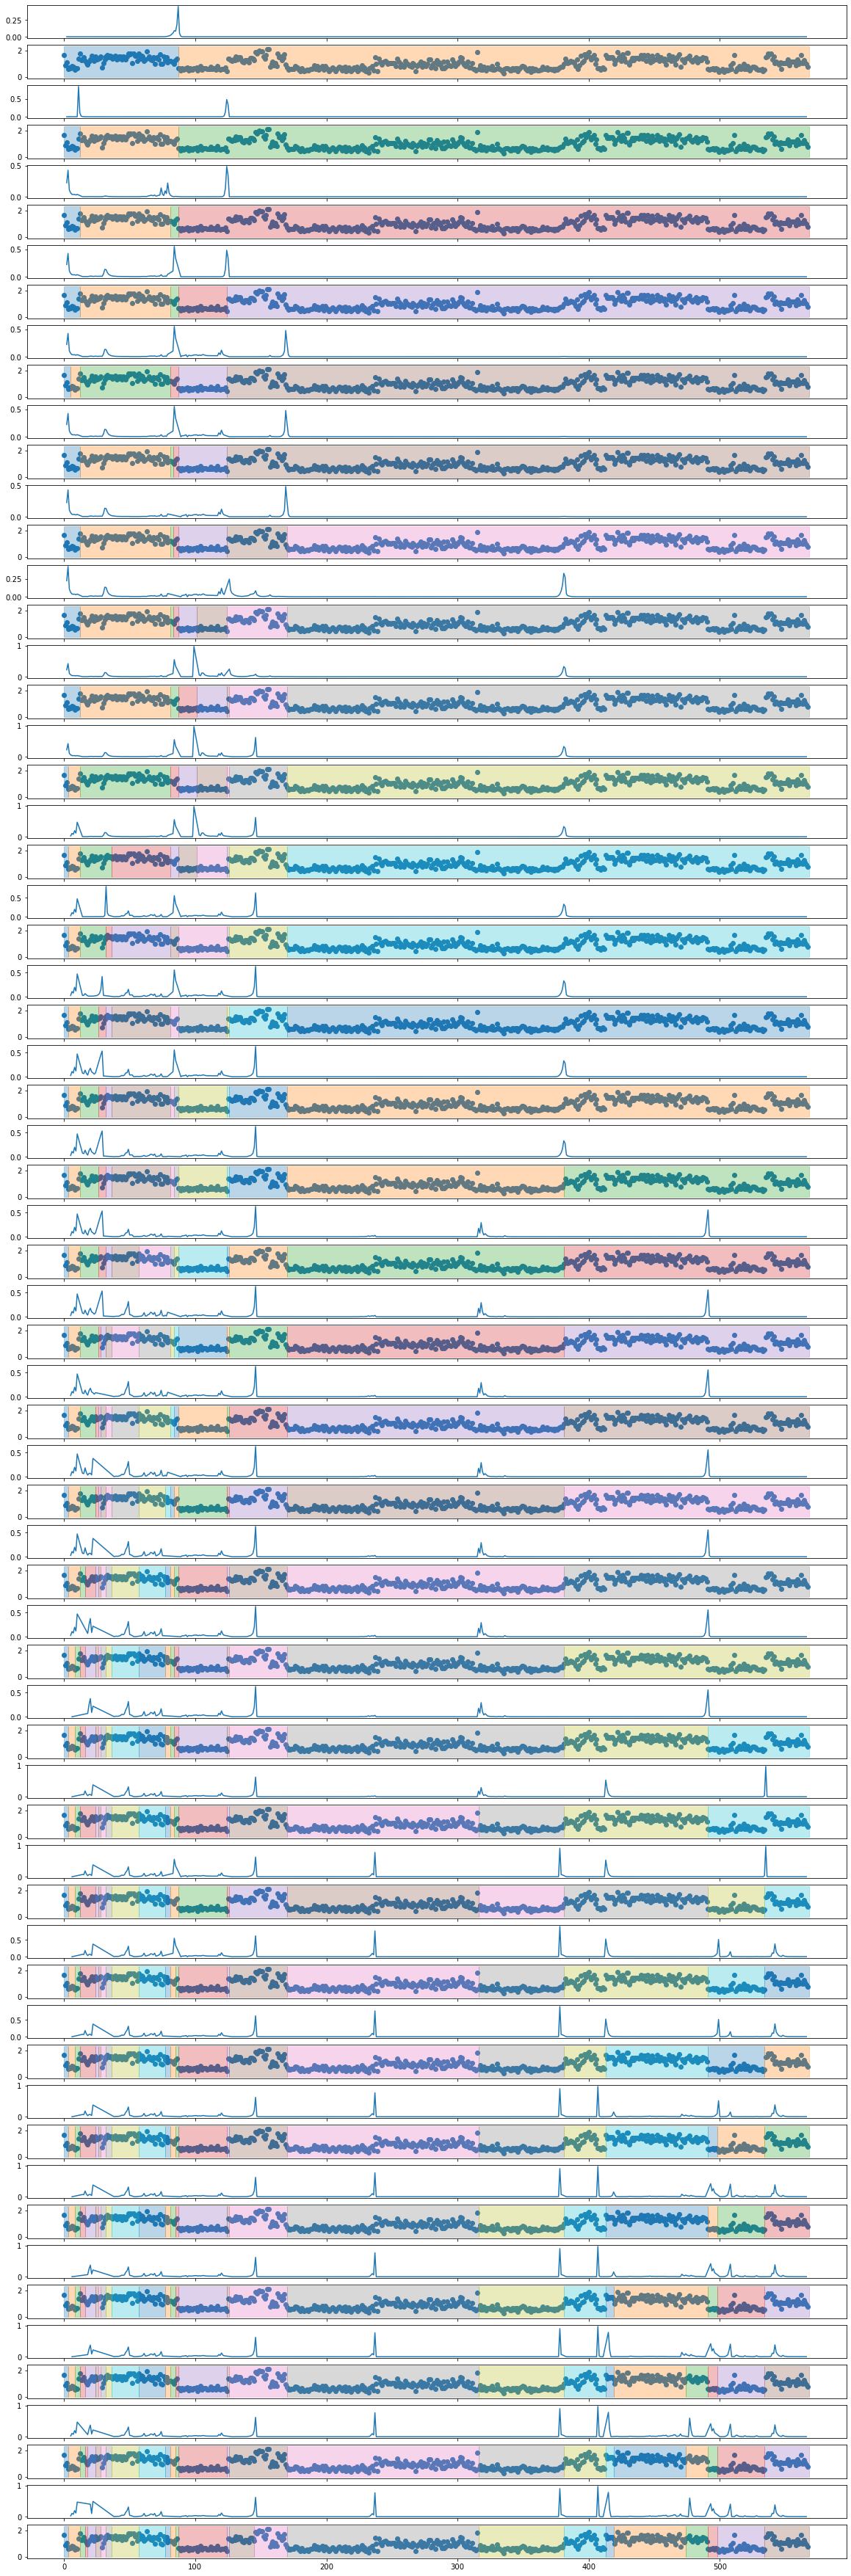

In [22]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,2 * len(traces)), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = np.exp(traces[i])
    nonzero = (trace != 1)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

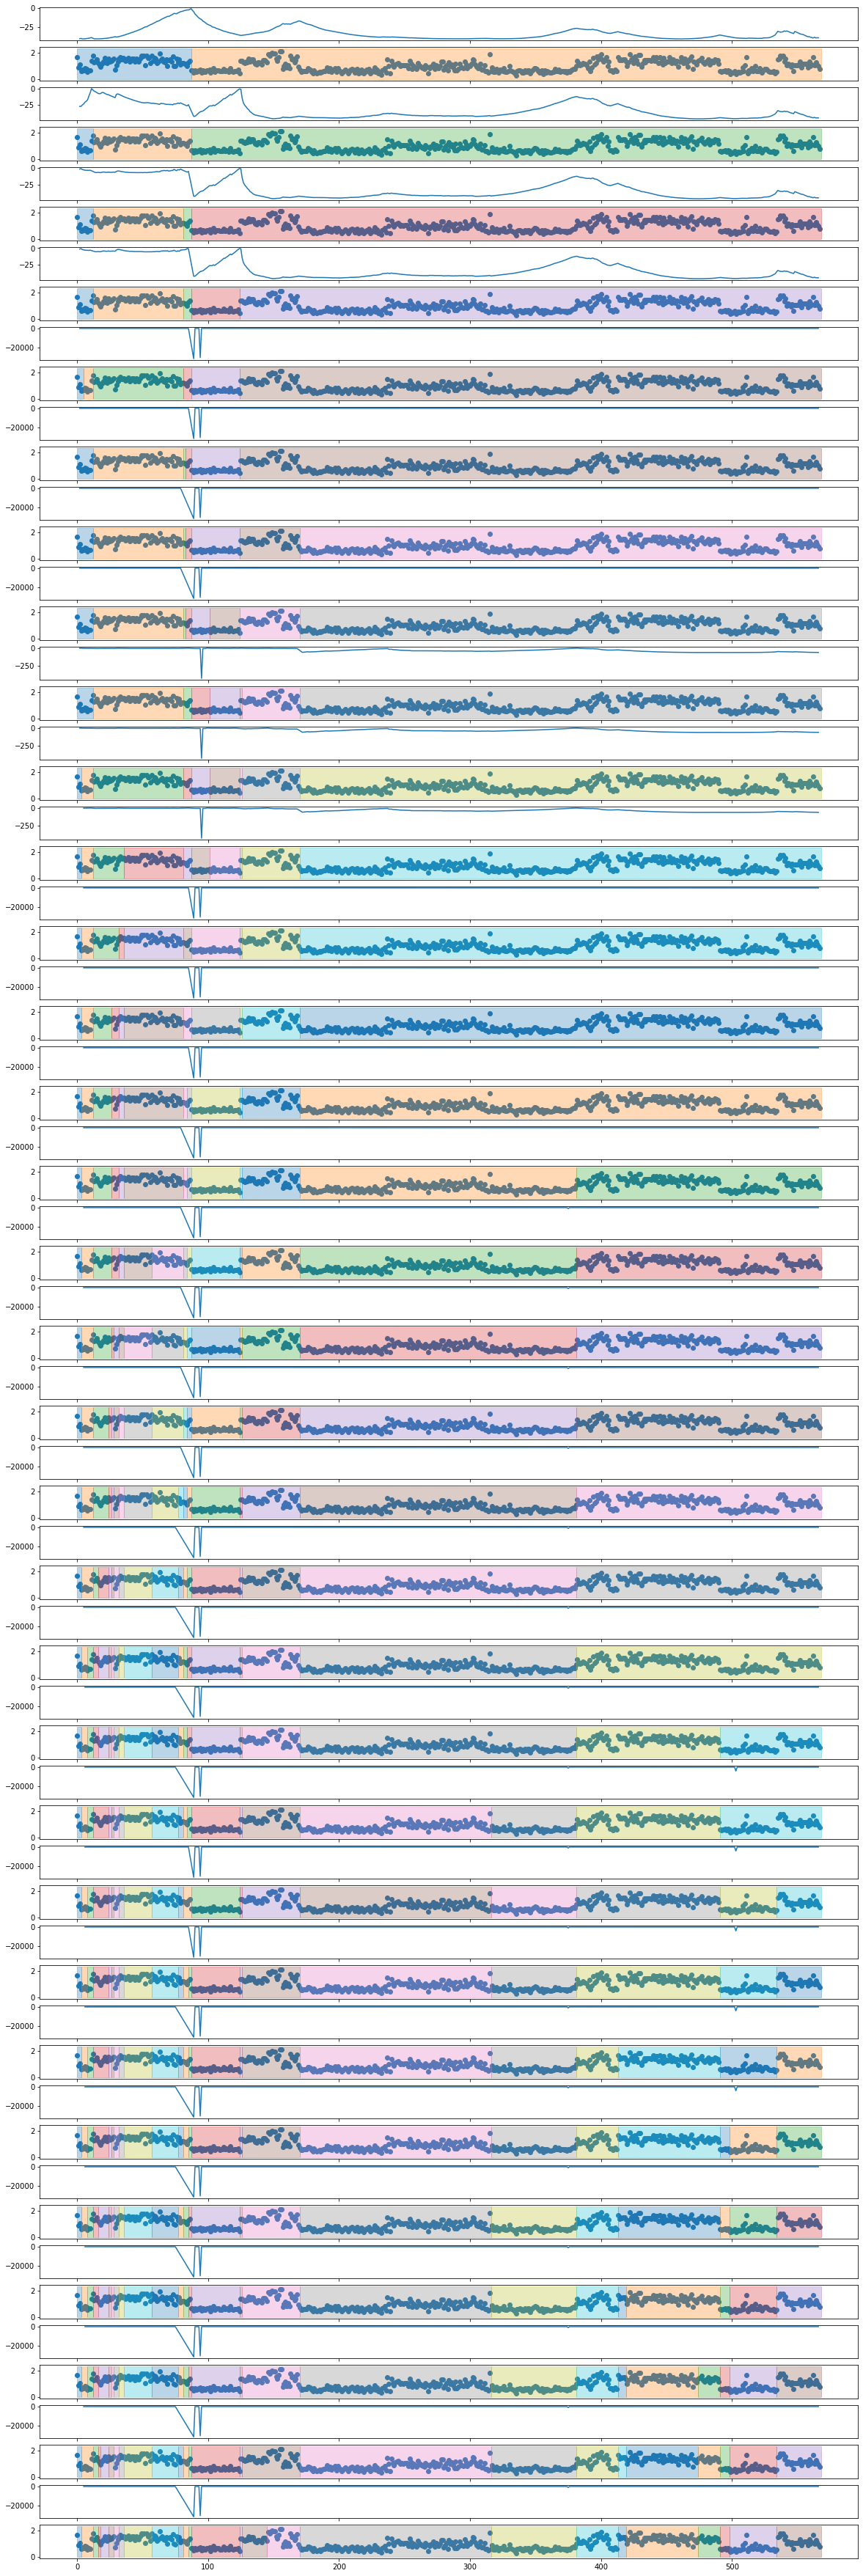

In [21]:
traces = nb_mcmc.clusters[1].ll_traces
f, axs = plt.subplots(2 * len(traces), figsize = (20,2 * len(traces)), sharex=True)
clus = 1
residuals = np.exp(np.log(nb_mcmc.clusters[clus].r) - (nb_mcmc.clusters[clus].mu) - (nb_mcmc.clusters[clus].C@nb_mcmc.clusters[clus].beta).flatten())
for i in range(len(traces)):
    trace = traces[i]
    nonzero = (trace != 0)
    #msk2 = (trace > trace.mean()*1.01)
    msk = nonzero
    axs[2*i].plot(np.r_[:len(trace)][msk], trace[msk])
    
    tst = np.array(nb_mcmc.clusters[1].phase_history[i]).reshape(-1,2)
    axs[2*i+1].scatter(np.r_[:len(residuals)], residuals)
    for j, r in enumerate(tst):
        axs[2*i+1].add_patch(matplotlib.patches.Rectangle((r[0],0), r[1]-r[0], 2.3, fill=True, alpha=0.3, color = colors[j % 10]))

still broken

checking discrepancies between statsmodels optmizer and our optimizer by saving stats opt and then using that as a starting point for our NR

In [19]:
nb_mcmc.run(100, debug=True)

  0%|          | 0/100 [00:00<?, ?it/s]

starting MCMC coverage segmentation...
SortedDict({0: 568})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 568)


  1%|          | 1/100 [00:08<13:40,  8.29s/it]

split log ml ratio:  32.483228043915915
split log mh ratio:  35.40998056722583
split!
SortedList([0, 88, 88, 568])
SortedDict({0: 88, 88: 480})
trying to split cluster 1
attempting split on segment:  88
ind:  (88, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)


s_ind: 88 (0, 88)


  2%|▏         | 2/100 [00:16<13:21,  8.18s/it]

split log ml ratio:  39.36582279664799
split log mh ratio:  40.111750782378294
split!
SortedList([0, 88, 88, 124, 124, 568])
SortedDict({0: 88, 88: 36, 124: 444})
trying to join cluster 1
attempting join on segs: 0 88
join ind:  (0, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  3%|▎         | 3/100 [00:18<08:34,  5.31s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 88, 88: 36, 124: 444})
trying to join cluster 1
attempting join on segs: 0 88
join ind:  (0, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
  4%|▍         | 4/100 [00:20<06:21,  3.97s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 88, 88: 36, 124: 444})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 88)
s_ind: 0 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (124, 568)


  5%|▌         | 5/100 [00:28<08:47,  5.56s/it]

split log ml ratio:  20.525548450306815
split log mh ratio:  20.697008187089523
split!
SortedList([0, 11, 11, 88, 88, 124, 124, 568])
SortedDict({0: 11, 11: 77, 88: 36, 124: 444})
trying to join cluster 1
attempting join on segs: 88 124
join ind:  (88, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
  6%|▌         | 6/100 [00:35<09:39,  6.16s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 11, 11: 77, 88: 36, 124: 444})
trying to split cluster 1
attempting split on segment:  0
ind:  (0, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 0 (11, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 0 (124, 568)


  7%|▋         | 7/100 [00:44<10:42,  6.91s/it]

split log ml ratio:  5.196672014107207
split log mh ratio:  5.422075470746677
split!
SortedList([0, 3, 3, 11, 11, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 8, 11: 77, 88: 36, 124: 444})
trying to split cluster 1
attempting split on segment:  3
ind:  (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 3 (11, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (124, 568)


  8%|▊         | 8/100 [00:52<11:21,  7.40s/it]

failing to converge. Trying grid search
split log ml ratio:  -0.6796641608116261
split log mh ratio:  -0.10008570267018513
split!
SortedList([0, 3, 3, 8, 8, 11, 11, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 5, 8: 3, 11: 77, 88: 36, 124: 444})
trying to join cluster 1
attempting join on segs: 88 124
join ind:  (88, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)


failing to converge. Trying grid search


  9%|▉         | 9/100 [00:59<11:07,  7.33s/it]

SortedDict({0: 3, 3: 5, 8: 3, 11: 77, 88: 36, 124: 444})
trying to split cluster 1
attempting split on segment:  88
ind:  (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 88 (11, 88)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (124, 568)


 10%|█         | 10/100 [01:08<11:28,  7.65s/it]

failing to converge. Trying grid search
split log ml ratio:  -3.1995726294917404
split log mh ratio:  0.10827933751625185
split!
SortedList([0, 3, 3, 8, 8, 11, 11, 88, 88, 103, 103, 124, 124, 568])
SortedDict({0: 3, 3: 5, 8: 3, 11: 77, 88: 15, 103: 21, 124: 444})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 3: 5, 8: 3, 11: 77, 88: 15, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 88 103
join ind:  (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid sear

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 8, 8, 11, 11, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 5, 8: 3, 11: 77, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 3 8
join ind:  (3, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


 13%|█▎        | 13/100 [01:10<04:52,  3.36s/it]

failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 11, 11, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 77, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 88 124
join ind:  (88, 568)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
 14%|█▍        | 14/100 [01:17<06:17,  4.39s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 3, 3: 8, 8: 3, 11: 77, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 3 11
join ind:  (3, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 15%|█▌        | 15/100 [01:18<04:53,  3.45s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 16%|█▌        | 16/100 [01:18<03:33,  2.54s/it]

SortedDict({0: 3, 3: 8, 8: 3, 11: 77, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 8, 8: 3, 11: 77, 88: 36, 103: 21, 124: 444})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 11 (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 11 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 11 (124, 568)


 17%|█▋        | 17/100 [01:26<05:49,  4.22s/it]

split log ml ratio:  2.4520442268667466
split log mh ratio:  6.176294294853506
split!
SortedList([0, 3, 3, 11, 11, 84, 84, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 73, 84: 4, 88: 36, 103: 21, 124: 444})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 11 (3, 11)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 11 (84, 88)
s_ind: 11 (88, 124)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 11 (124, 568)


 19%|█▉        | 19/100 [01:35<05:17,  3.91s/it]

split log ml ratio:  -1.471176539775115
split log mh ratio:  4.626193506212076
split!
SortedList([0, 3, 3, 11, 11, 67, 67, 84, 84, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 17, 84: 4, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 67 84
join ind:  (67, 88)
joining!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 11)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 20%|██        | 20/100 [01:35<03:45,  2.82s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 124: 444})
trying to join cluster 1
attempting join on segs: 3 11
join ind:  (3, 67)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 21%|██        | 21/100 [01:36<02:57,  2.24s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 124: 444})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 124: 444})
trying to split cluster 1
attempting split on segment:  88
ind:  (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 88 (11, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (67, 88)
s_ind: 88 (124, 568)


 23%|██▎       | 23/100 [01:46<04:29,  3.50s/it]

failing to converge. Trying grid search
split log ml ratio:  -2.323054027728176
split log mh ratio:  0.22047389471663426
split!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 118, 118, 124, 124, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 30, 103: 21, 118: 6, 124: 444})
trying to join cluster 1
attempting join on segs: 88 118
join ind:  (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 124, 124, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 444})
trying to join cluster 1
attempting join on segs: 11 67
join ind:  (11, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search


 25%|██▌       | 25/100 [01:48<03:01,  2.42s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 26%|██▌       | 26/100 [01:49<02:14,  1.82s/it]

SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 444})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 444})
trying to join cluster 1
attempting join on segs: 11 67
join ind:  (11, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search


 27%|██▋       | 27/100 [01:49<01:53,  1.55s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 444})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 28%|██▊       | 28/100 [01:50<01:25,  1.18s/it]

failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 444})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 568)
s_ind: 124 (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 124 (11, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 124 (67, 88)
s_ind: 124 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
split log ml ratio:  24.886346407368364
split log mh ratio:  25.61884150423157
split!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 124, 124, 169, 169, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 45, 169: 399})
trying to join cluster 1
attempting join on segs: 67 88
join ind:  (67, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 30%|███       | 30/100 [02:01<03:25,  2.94s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 45, 169: 399})
trying to split cluster 1
attempting split on segment:  124
ind:  (124, 169)
s_ind: 124 (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 124 (11, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 124 (67, 88)
s_ind: 124 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 124 (169, 568)


 31%|███       | 31/100 [02:09<05:11,  4.51s/it]

split log ml ratio:  3.694961750848961
split log mh ratio:  5.141621746596684
split!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 124, 124, 126, 126, 169, 169, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 43, 169: 399})
trying to join cluster 1
attempting join on segs: 67 88
join ind:  (67, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 32%|███▏      | 32/100 [02:10<03:58,  3.51s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 43, 169: 399})
trying to split cluster 1
attempting split on segment:  169
ind:  (169, 568)
s_ind: 169 (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 169 (11, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (67, 88)
s_ind: 169 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (126, 169)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 33%|███▎      | 33/100 [02:19<05:46,  5.17s/it]

split log ml ratio:  55.29320455076686
split log mh ratio:  57.79450904762143
split!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 124, 124, 126, 126, 169, 169, 379, 379, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 43, 169: 210, 379: 189})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 169)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying gri

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 126 (11, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (67, 88)
s_ind: 126 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (169, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 34%|███▍      | 34/100 [02:29<07:06,  6.47s/it]

split log ml ratio:  9.2615458975597
split log mh ratio:  9.727829709385333
split!
SortedList([0, 3, 3, 11, 11, 67, 67, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 379, 379, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to join cluster 1
attempting join on segs: 3 11
join ind:  (3, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 35%|███▌      | 35/100 [02:29<05:11,  4.80s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to join cluster 1
attempting join on segs: 124 126
join ind:  (124, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 36%|███▌      | 36/100 [02:30<03:45,  3.53s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to join cluster 1
attempting join on segs: 146 169
join ind:  (146, 379)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Tr

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 37%|███▋      | 37/100 [02:34<03:51,  3.68s/it]

SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to join cluster 1
attempting join on segs: 11 67
join ind:  (11, 88)
failing to converge. Trying grid search
failing to converge. Trying grid search


 38%|███▊      | 38/100 [02:35<02:55,  2.84s/it]

SortedDict({0: 3, 3: 8, 8: 3, 11: 56, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to split cluster 1
attempting split on segment:  11
ind:  (11, 67)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 11 (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 11 (67, 88)
s_ind: 11 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 11 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 11 (169, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 39%|███▉      | 39/100 [02:44<04:47,  4.72s/it]

split log ml ratio:  1.4245605144078581
split log mh ratio:  4.756513210764751
split!
SortedList([0, 3, 3, 11, 11, 35, 35, 67, 67, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 379, 379, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to split cluster 1
attempting split on segment:  124
SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to join cluster 1
attempting join on segs: 169 379
join ind:  (169, 568)


 41%|████      | 41/100 [02:49<03:43,  3.80s/it]

SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 169)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 42%|████▏     | 42/100 [02:50<02:56,  3.05s/it]

SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 210, 379: 189})
trying to split cluster 1
attempting split on segment:  169
ind:  (169, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying gr

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 169 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (67, 88)
s_ind: 169 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 169 (379, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 43%|████▎     | 43/100 [03:00<04:27,  4.69s/it]

split log ml ratio:  21.05290910313579
split log mh ratio:  26.12229566080623
split!
SortedList([0, 3, 3, 11, 11, 35, 35, 67, 67, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 325, 325, 379, 379, 568])
SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 146 169
join ind:  (146, 325)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 45%|████▌     | 45/100 [03:02<02:55,  3.20s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


trying stats opt
SortedDict({0: 3, 3: 8, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  3
ind:  (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 3 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (67, 88)
s_ind: 3 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge.

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (169, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 3 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fai

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


 46%|████▌     | 46/100 [03:11<04:06,  4.56s/it]

failing to converge. Trying grid search
split log ml ratio:  -0.6796641608125356
split log mh ratio:  -0.10008570267109462
split!
SortedList([0, 3, 3, 8, 8, 11, 11, 35, 35, 67, 67, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 325, 325, 379, 379, 568])
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 325 379
join ind:  (325, 568)


 47%|████▋     | 47/100 [03:14<03:37,  4.11s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


 48%|████▊     | 48/100 [03:14<02:40,  3.08s/it]

SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 124 126
join ind:  (124, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 49%|████▉     | 49/100 [03:15<02:01,  2.38s/it]

failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 21, 84: 4, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  67
ind:  (67, 88)
s_ind: 67 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 67 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fai

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 67 (169, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 67 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 67 (379, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


 50%|█████     | 50/100 [03:24<03:32,  4.25s/it]

split log ml ratio:  1.435502005264425
split log mh ratio:  3.1509342162835305
split!
SortedList([0, 3, 3, 8, 8, 11, 11, 35, 35, 67, 67, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 325, 325, 379, 379, 568])
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 146 169
join ind:  (146, 325)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 51%|█████     | 51/100 [03:26<03:00,  3.68s/it]

trying stats opt
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 169)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid s

 52%|█████▏    | 52/100 [03:27<02:16,  2.84s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 88 124
join ind:  (88, 126)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid sea

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
 53%|█████▎    | 53/100 [03:27<01:46,  2.27s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  3
ind:  (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 3 (11, 35)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (67, 86)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (88, 124)
failing to converge. Trying grid search
failing 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge.

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (169, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 3 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fai

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


 54%|█████▍    | 54/100 [03:36<03:15,  4.24s/it]

failing to converge. Trying grid search
split log ml ratio:  -1.5471396377424753
split log mh ratio:  -1.5471396377424753
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  8
SortedDict({0: 3, 3: 5, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  3
ind:  (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 3 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (67, 86)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tryin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge.

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 3 (146, 169)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 3 (169, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 3 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fai

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 3 (379, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


 56%|█████▌    | 56/100 [03:45<03:12,  4.37s/it]

failing to converge. Trying grid search
split log ml ratio:  -1.5471396377424753
split log mh ratio:  -1.5471396377424753
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 325, 325, 379, 379, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 86 88
join ind:  (86, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge.

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 57%|█████▋    | 57/100 [03:46<02:31,  3.52s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to join cluster 1
attempting join on segs: 67 86
join ind:  (67, 88)


 58%|█████▊    | 58/100 [03:47<01:51,  2.65s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 189})
trying to split cluster 1
attempting split on segment:  379
ind:  (379, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
s_ind: 379 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (67, 86)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. T

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (169, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 379 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
f

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 59%|█████▉    | 59/100 [03:56<03:01,  4.42s/it]

split log ml ratio:  36.21512469878053
split log mh ratio:  37.410562752708756
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 325, 325, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 169 325
join ind:  (169, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
f

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 60%|██████    | 60/100 [03:59<02:43,  4.08s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  8
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 0 3
join ind:  (0, 5)
failing to converge. Trying grid search
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  86
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 156, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  169
ind:  (169, 325

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 169 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (67, 86)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. T

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 169 (490, 568)


 64%|██████▍   | 64/100 [04:08<01:47,  2.99s/it]

split log ml ratio:  38.38491343146052
split log mh ratio:  40.36312064649519
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 235, 235, 325, 325, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 66, 235: 90, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  0
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 66, 235: 90, 325: 54, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 126 146
join ind:  (126, 169)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid s

 66%|██████▌   | 66/100 [04:09<01:14,  2.19s/it]

SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 19, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 66, 235: 90, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  67
ind:  (67, 86)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fai

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 67 (169, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 67 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 67 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 67 (490, 568)


 67%|██████▋   | 67/100 [04:18<01:51,  3.38s/it]

split log ml ratio:  -0.15018632761166373
split log mh ratio:  1.7265707700107669
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 235, 235, 325, 325, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 6, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 66, 235: 90, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  169
ind:  (169, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 169 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (67, 80)
s_ind: 169 (80, 86)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 169 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 169 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 169 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 169 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
f

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 169 (490, 568)


 68%|██████▊   | 68/100 [04:27<02:24,  4.51s/it]

split log ml ratio:  -2.076650885537674
split log mh ratio:  1.3998414341167518
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 6, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 54, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 146 169
join ind:  (146, 214)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 69%|██████▉   | 69/100 [04:28<01:54,  3.69s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 6, 84: 4, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  80
ind:  (80, 86)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (67, 80)
s_ind: 80 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Try

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 80 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 80 (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 80 (490, 568)


 70%|███████   | 70/100 [04:37<02:28,  4.97s/it]

failing to converge. Trying grid search
split log ml ratio:  0.3605866686812078
split log mh ratio:  1.277238266429777
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 54, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 35 67
join ind:  (35, 80)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 71%|███████   | 71/100 [04:37<01:52,  3.87s/it]

SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 54, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 325 379
join ind:  (325, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 54, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  325
ind:  (325, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid searc

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 325 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 325 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 325 (67, 80)
s_ind: 325 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 325 (88, 124)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 325 (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converg

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 325 (146, 169)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 325 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 325 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 325 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 325 (379, 490)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 325 (490, 568)


 73%|███████▎  | 73/100 [04:48<02:11,  4.89s/it]

split log ml ratio:  1.6398056171010467
split log mh ratio:  4.1430640562603
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 124, 124, 126, 126, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  84
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 235 325
join ind:  (235, 337)


 75%|███████▌  | 75/100 [04:49<01:13,  2.96s/it]

SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 78})
trying to join cluster 1
attempting join on segs: 86 88
join ind:  (86, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 76%|███████▌  | 76/100 [04:50<00:59,  2.47s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 20, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 126 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (67, 80)
s_ind: 126 (80, 84)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 126 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (146, 169)
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 126 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 126 (325, 337)
s_ind: 126 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (379, 490)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 126 (490, 568)


 77%|███████▋  | 77/100 [04:59<01:35,  4.17s/it]

failing to converge. Trying grid search
split log ml ratio:  -2.8750876071862876
split log mh ratio:  -0.09965309619383333
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 124, 124, 126, 126, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 490, 490, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 8, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 78})
trying to split cluster 1
attempting split on segment:  490
ind:  (490, 568)
s_ind: 490 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failin

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (67, 80)
s_ind: 490 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 490 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (126, 134)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 490 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 490 (325, 337)
s_ind: 490 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
s_ind: 490 (379, 490)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
split log ml ratio:  28.136730217904187
split log mh ratio:  28.180918964437296
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 124, 124, 126, 126, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 490, 490, 535, 535, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 8, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  80
ind:  (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 80 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (67, 80)
s_ind: 80 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (126, 134)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. 

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 80 (146, 169)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 80 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 80 (325, 337)
s_ind: 80 (337, 379)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tr

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 80 (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 80 (535, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:360: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 79%|███████▉  | 79/100 [05:17<02:15,  6.47s/it]

failing to converge. Trying grid search
split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 8, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 45, 535: 33})
trying to join cluster 1
attempting join on segs: 214 235
join ind:  (214, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 80%|████████  | 80/100 [05:19<01:40,  5.01s/it]/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 8, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 111, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  379
ind:  (379, 490)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 379 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (67, 80)
s_ind: 379 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 379 (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (126, 134)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 379 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 379 (325, 337)
s_ind: 379 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

reached singular matrix. reseeting with grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 379 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian f

failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 81%|████████  | 81/100 [05:28<01:58,  6.22s/it]

split log ml ratio:  13.952631650297917
split log mh ratio:  20.083051208730467
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 124, 124, 126, 126, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 422, 422, 490, 490, 535, 535, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 8, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  126
ind:  (126, 134)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying g

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (67, 80)
s_ind: 126 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 126 (88, 124)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (146, 169)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tryi

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 126 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 126 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 126 (325, 337)
s_ind: 126 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fa

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
s_ind: 126 (379, 422)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (422, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

s_ind: 126 (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 126 (535, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 82%|████████▏ | 82/100 [05:37<02:07,  7.09s/it]

failing to converge. Trying grid search
split log ml ratio:  -2.008798405872767
split log mh ratio:  0.19908887122892338
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 124, 124, 126, 126, 129, 129, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 422, 422, 490, 490, 535, 535, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 36, 103: 21, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  88
ind:  (88, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid se

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:238: RuntimeWarning: overflow encountered in multiply
  (self.epsi_i * (self.exp + self.epsi_i) ** 2)).sum(0)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (67, 80)
s_ind: 88 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 88 (129, 134)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (146, 169)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying g

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 88 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 88 (325, 337)
s_ind: 88 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fail

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (422, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 88 (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (535, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 83%|████████▎ | 83/100 [05:46<02:10,  7.70s/it]

failing to converge. Trying grid search
split log ml ratio:  -3.4997344245120985
split log mh ratio:  0.06289105541509343
split!
SortedList([0, 3, 3, 5, 5, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 108, 108, 124, 124, 126, 126, 129, 129, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 422, 422, 490, 490, 535, 535, 568])
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to join cluster 1
attempting join on segs: 214 235
join ind:  (214, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 84%|████████▍ | 84/100 [05:48<01:33,  5.83s/it]

failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  88
ind:  (88, 108)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 88 (11, 35)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (67, 80)
s_ind: 88 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

s_ind: 88 (108, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (129, 134)
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (146, 169)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying

/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
s_ind: 88 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 88 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
s_ind: 88 (325, 337)
s_ind: 88 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fail

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (422, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

trying stats opt
s_ind: 88 (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 88 (535, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:360: RuntimeWarning: invalid value encountered in log
  return np.log(2 * np.pi) - (np.log(np.linalg.det(-H1) * np.linalg.det(-H2))) / 2
 85%|████████▌ | 85/100 [05:56<01:40,  6.73s/it]

split log ml ratio:  nan
split log mh ratio:  nan
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to join cluster 1
attempting join on segs: 169 214
join ind:  (169, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 86%|████████▌ | 86/100 [05:57<01:08,  4.92s/it]

failing to converge. Trying grid search
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  126
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to join cluster 1
attempting join on segs: 86 88
join ind:  (86, 108)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 88%|████████▊ | 88/100 [05:57<00:32,  2.73s/it]

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
SortedDict({0: 3, 3: 2, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to join cluster 1
attempting join on segs: 3 5
join ind:  (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████▉ | 89/100 [05:58<00:23,  2.09s/it]/home/opriebe/anaco

trying stats opt
failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 108, 108, 124, 124, 126, 126, 129, 129, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 422, 422, 490, 490, 535, 535, 568])
SortedDict({0: 3, 3: 5, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to join cluster 1
attempting join on segs: 337 379
join ind:  (337, 422)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
SortedDict({0: 3, 3: 5, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  35
ind:  (35, 67)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 35 (11, 35)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (67, 80)
s_ind: 35 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 35 (88, 108)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 35 (108, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (129, 134)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 35 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (146, 169)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 35 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 35 (325, 337)
s_ind: 35 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
fail

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (422, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

trying stats opt
s_ind: 35 (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 35 (535, 568)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian f

failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


 91%|█████████ | 91/100 [06:08<00:34,  3.81s/it]

split log ml ratio:  -4.177182174243171
split log mh ratio:  -4.120806814033131
SortedDict({0: 3, 3: 5, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  84
SortedDict({0: 3, 3: 5, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 45, 535: 33})
trying to split cluster 1
attempting split on segment:  490
ind:  (490, 535)


/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:165: RuntimeWarning: overflow encountered in exp
  self.exp = np.exp(self.mu + (self.C[ind[0]:ind[1]] @ self.beta).flatten() + self.mu_i)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:226: RuntimeWarning: invalid value encountered in true_divide
  return ((self.epsi_i * (self.r[ind[0]:ind[1]] - self.exp)) / (self.epsi_i + self.exp)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:232: RuntimeWarning: invalid value encountered in true_divide
  return (-(self.exp * self.epsi_i * (self.r[ind[0]: ind[1]] + self.epsi_i)) /
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/oprieb

hit a nan in optimizer, reseting
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (3, 8)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 490 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (67, 80)
s_ind: 490 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 490 (88, 108)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 490 (108, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (129, 134)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (146, 169)
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 490 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 490 (325, 337)
s_ind: 490 (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tr

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 490 (422, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

s_ind: 490 (535, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 93%|█████████▎| 93/100 [06:17<00:28,  4.10s/it]

split log ml ratio:  1.6857564038318742
split log mh ratio:  4.312982514906253
split!
SortedList([0, 3, 3, 8, 8, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 108, 108, 124, 124, 126, 126, 129, 129, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 422, 422, 490, 490, 527, 527, 535, 535, 568])
SortedDict({0: 3, 3: 5, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 37, 527: 8, 535: 33})
trying to join cluster 1
attempting join on segs: 3 8
join ind:  (3, 11)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
 94%|█████████▍| 94/100 [06:17<00:19,  3.19s/it]

trying stats opt
failing to converge. Trying grid search
joining!
SortedList([0, 3, 3, 11, 11, 35, 35, 67, 67, 80, 80, 84, 84, 86, 86, 88, 88, 108, 108, 124, 124, 126, 126, 129, 129, 134, 134, 146, 146, 169, 169, 214, 214, 235, 235, 325, 325, 337, 337, 379, 379, 422, 422, 490, 490, 527, 527, 535, 535, 568])
SortedDict({0: 3, 3: 8, 5: 3, 8: 3, 11: 24, 35: 32, 67: 13, 80: 4, 84: 2, 86: 2, 88: 20, 103: 21, 108: 16, 118: 6, 124: 2, 126: 3, 129: 5, 134: 12, 146: 23, 169: 45, 214: 21, 235: 90, 325: 12, 337: 42, 379: 43, 422: 68, 490: 37, 527: 8, 535: 33})
trying to split cluster 1
attempting split on segment:  337
ind:  (337, 379)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Tr

/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: divide by zero encountered in log
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:229: RuntimeWarning: invalid value encountered in multiply
  return (ss.digamma(self.r[ind[0]: ind[1]] + self.epsi_i) - ss.digamma(self.epsi_i) + (self.exp - self.r[ind[0]: ind[1]] + self.exp * np.log(self.epsi_i / (self.exp + self.epsi_i)) + self.epsi_i * np.log(self.epsi_i / (self.exp + self.epsi_i))) /(self.exp + self.epsi_i)).sum(0)
/home/opriebe/dev/HapASeg/hapaseg/NB_coverage_MCMC.py:237: RuntimeWarning: divide by zero encountered in true_divide
  ss.polygamma(1, self.epsi_i) + (self.exp ** 2 + self.r[ind[0]: ind[1]] * self.epsi_i) /
/home/oprie

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 337 (11, 35)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/mode

failing to converge. Trying grid search
s_ind: 337 (35, 67)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (67, 80)
s_ind: 337 (80, 84)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


s_ind: 337 (88, 108)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 337 (108, 124)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (129, 134)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (134, 146)
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (146, 169)
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.p

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (169, 214)
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (214, 235)


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
s_ind: 337 (235, 325)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
trying stats opt
s_ind: 337 (325, 337)
s_ind: 337 (379, 422)
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (422, 490)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optim

failing to converge. Trying grid search
trying stats opt
s_ind: 337 (490, 527)
failing to converge. Trying grid search
failing to converge. Trying grid search
trying stats opt
s_ind: 337 (527, 535)
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/bas

failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
failing to converge. Trying grid search
s_ind: 337 (535, 568)
failing to converge. Trying grid search
trying stats opt
failing to converge. Trying grid search


/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2642: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/opriebe/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian f

failing to converge. Trying grid search
failing to converge. Trying grid search


KeyboardInterrupt: 

Text(0, 0.5, 'our_NR')

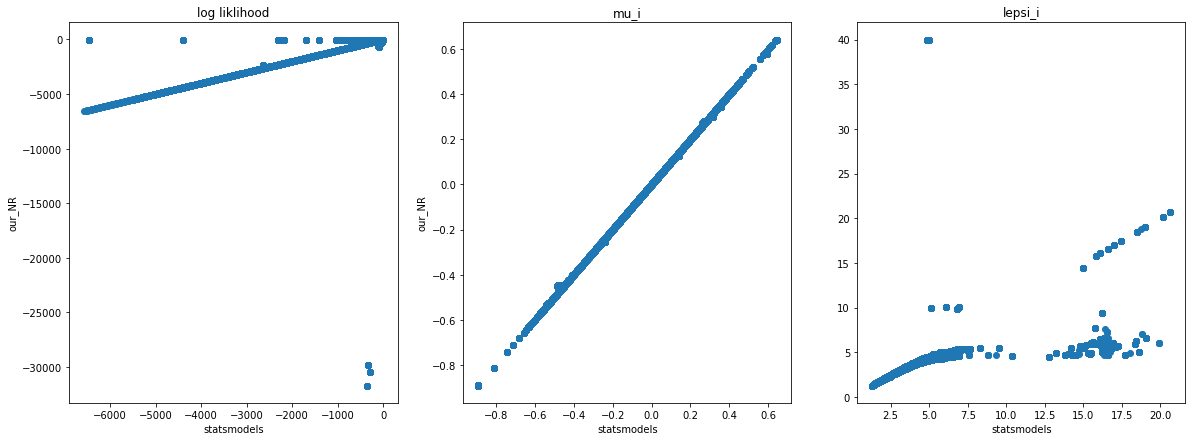

In [42]:
f, axs = plt.subplots(1,3,figsize=(20,7))

lls = np.array([(v[1], v[4]) for v in nb_mcmc.clusters[1].opt_views])
axs[0].scatter(lls[:,0], lls[:,1])
axs[0].set_title('log liklihood')
axs[0].set_xlabel('statsmodels')
axs[0].set_ylabel('our_NR')

lls = np.array([(v[2], v[5]) for v in nb_mcmc.clusters[1].opt_views])
axs[1].scatter(lls[:,0], lls[:,1])
axs[1].set_title('mu_i')
axs[1].set_xlabel('statsmodels')
axs[1].set_ylabel('our_NR')

lls = np.array([(v[3], v[6]) for v in nb_mcmc.clusters[1].opt_views])
axs[2].scatter(lls[:,0], lls[:,1])
axs[2].set_title('lepsi_i')
axs[2].set_xlabel('statsmodels')
axs[1].set_ylabel('our_NR')